<a href="https://colab.research.google.com/github/gerardtomaszewski/ml_w_finansach/blob/main/Zadanie2_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install surprise
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import KNNWithMeans, SVD
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split, GridSearchCV, cross_validate


In [58]:
ratings = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv')
movies = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv')

Zadanie 1.1

In [5]:
n_movies = movies[movies['genres'].str.contains('Sci-Fi')]
n_movies = n_movies['movieId'].nunique()
print(n_movies)

980


Zadanie 2.2

In [8]:
df = pd.merge(ratings, movies, on='movieId')
filtered_df = df[df['genres'].str.contains('Comedy')]

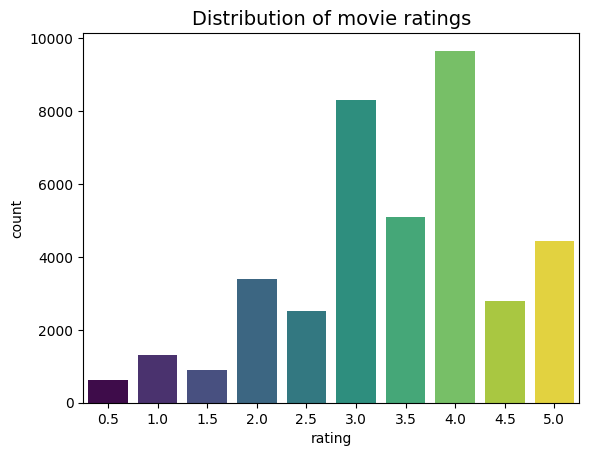

In [9]:
sns.countplot(x="rating", data=filtered_df, palette="viridis", hue='rating', legend=False)
plt.title("Distribution of movie ratings", fontsize=14)
plt.show()

In [10]:
filtered_df = df[df['genres'].str.contains('Action')]

In [11]:
print(f"Mean global rating: {round(filtered_df['rating'].mean(),2)}.")

Mean global rating: 3.45.


In [16]:
mean_ratings = filtered_df.groupby(['movieId','title'])[['rating']].mean().reset_index()
top_ratings = mean_ratings.sort_values(by='rating', ascending=False).head(3)
print(top_ratings[['title']])

                                                  title
1239             Love Exposure (Ai No Mukidashi) (2008)
1692                                 Tokyo Tribe (2014)
1593  Crippled Avengers (Can que) (Return of the 5 D...


In [18]:
movie_stats = filtered_df.groupby('movieId')[['rating']].agg(['count', 'mean'])
movie_stats.columns = movie_stats.columns.droplevel()

C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return bayesian_avg

bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']

movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')
movie_stats = movie_stats.merge(movies[['movieId', 'title']])
top_ratings = movie_stats.sort_values('bayesian_avg', ascending=False).head(3)
print(top_ratings[['title']])

                                                 title
362                                  Fight Club (1999)
36           Star Wars: Episode IV - A New Hope (1977)
135  Star Wars: Episode V - The Empire Strikes Back...


Zadanie 2

In [59]:
min_rating = ratings.rating.min()
max_rating = ratings.rating.max()

reader = Reader(rating_scale=(min_rating, max_rating))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

algo = KNNWithMeans()

cv_KNNWithMeans = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=True)
print(np.mean(cv_KNNWithMeans['test_rmse']))

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8960  0.8975  0.9008  0.8961  0.8966  0.8974  0.0018  
Fit time          0.17    0.16    0.16    0.16    0.16    0.16    0.00    
Test time         1.76    1.58    1.41    1.38    1.36    1.50    0.15    
0.897396281202924


In [127]:
param_grid = {'k': list(range(2, 7)), 'sim_options':{'user_based': [False]}}
grid_search = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse'], cv=5)
grid_search.fit(data)


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In [137]:
grid_search.best_params['rmse']['k']

6

In [141]:
dataset = data.build_full_trainset()
algo = grid_search.best_estimator['rmse']
algo.fit(dataset)
inner_id = algo.trainset.to_inner_iid(2)
top_movies = algo.get_neighbors(inner_id,k=5)
neighbors = (
    algo.trainset.to_raw_iid(inner_id) for inner_id in top_movies
)
neighbors = (dict(zip(movies['movieId'], movies['title']))[rid] for rid in neighbors)

print()
print("The top 5 recommended movies for Jumanji are:")
for movie in neighbors:
    print(movie)

Computing the msd similarity matrix...
Done computing similarity matrix.

The top 5 recommended movies for Jumanji are:
Return to Oz (1985)
20 Dates (1998)
Shaft (1971)
Piranha (1978)
Hangar 18 (1980)


In [142]:
trainset = data.build_full_trainset()

algo = grid_search.best_estimator['rmse']
algo.fit(trainset)
inner_id = algo.trainset.to_inner_iid(193585)
top_movies = algo.get_neighbors(inner_id,k=5)
neighbors = (
    algo.trainset.to_raw_iid(inner_id) for inner_id in top_movies
)
neighbors = (dict(zip(movies['movieId'], movies['title']))[rid] for rid in neighbors)

print()
print("The top 5 recommended movies for Flint are:")
for movie in neighbors:
    print(movie)

Computing the msd similarity matrix...
Done computing similarity matrix.

The top 5 recommended movies for Flint are:
X-Men (2000)
Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)
Avengers: Age of Ultron (2015)
Kingsman: The Golden Circle (2017)
Insomnia (2002)


In [146]:
algo = SVD()
algo.fit(trainset)

inner_item_id = trainset.to_inner_iid(2)

movie_ratings = []
for uid in trainset.all_users():
    prediction = algo.predict(uid, inner_item_id)
    movie_ratings.append((uid, prediction.est))

sorted_ratings = sorted(movie_ratings, key=lambda x: x[1], reverse=True)

k = 5
recommended_movie_ids = [algo.trainset.to_raw_iid(inner_id) for inner_id, _ in sorted_ratings[:k]]
recommended_movies = [dict(zip(movies['movieId'], movies['title']))[movie_id] for movie_id in recommended_movie_ids]

print("The top {} recommended movies similar to Jumanji are:".format(k))
for movie in recommended_movies:
    print(movie)

The top 5 recommended movies similar to Jumanji are:
Dumbo (1941)
She's the One (1996)
Swan Princess, The (1994)
Closet, The (Placard, Le) (2001)
Clerks (1994)


In [145]:
algo = SVD()
algo.fit(trainset)

inner_item_id = trainset.to_inner_iid(2)

movie_ratings = []
for uid in trainset.all_users():
    prediction = algo.predict(uid, inner_item_id)
    movie_ratings.append((uid, prediction.est))

sorted_ratings = sorted(movie_ratings, key=lambda x: x[1], reverse=True)

k = 5
recommended_movie_ids = [algo.trainset.to_raw_iid(inner_id) for inner_id, _ in sorted_ratings[:k]]
recommended_movies = [dict(zip(movies['movieId'], movies['title']))[movie_id] for movie_id in recommended_movie_ids]

print("The top {} recommended movies similar to Flint are:".format(k))
for movie in recommended_movies:
    print(movie)

The top 5 recommended movies similar to Flint are:
Dumbo (1941)
She's the One (1996)
Closet, The (Placard, Le) (2001)
Broken Arrow (1996)
Star Wars: Episode I - The Phantom Menace (1999)


Zadanie 2.2:

kNN with means uwzględnia średnie wartości ocen użytkowników, kNNBasic używa bezpośrednio ocen.

In [147]:
cross_validate(algo, data,measures=['rmse'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8674  0.8771  0.8839  0.8782  0.8619  0.8737  0.0079  
Fit time          1.33    1.36    1.37    1.66    1.52    1.45    0.12    
Test time         0.11    0.36    0.18    0.18    0.41    0.25    0.12    


{'test_rmse': array([0.86735225, 0.87713735, 0.88389994, 0.87815187, 0.86192496]),
 'fit_time': (1.3338661193847656,
  1.360719919204712,
  1.373276710510254,
  1.6567647457122803,
  1.5164422988891602),
 'test_time': (0.11189651489257812,
  0.36484456062316895,
  0.17626595497131348,
  0.18465471267700195,
  0.40935802459716797)}